# Run Gillespie algorithm 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [24]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tnrange, tqdm_notebook

from run_sim import run_sim
from birth_death_model import BirthDeathModel
from lotka_volterra_model import LotkaVolterraModel
from goutsias_model import GoutsiasModel
from gene_toggle_model import GeneToggleModel

########################
# Birth-death model
########################

# model = BirthDeathModel()
# species = ['A', 'B'] #should be part of the model, but Numba does not support strings
# initial_dist = {(5, 5): 1.}
# t_end = 0.01

########################
# Lokta-Volterra model
########################

# model = LotkaVolterraModel()
# species = ['A', 'B']
# initial_dist = {(150, 100): 1.}
# t_end = 0.1

########################
# Gene toggle model
########################

model = GeneToggleModel()
species = ['A', 'B']
initial_dist = {(1, 10): 1.}
t_end = 1
########################
# Goutsias model
########################

# model = GoutsiasModel()
# species = ['A', 'B', 'RNA', 'DNA', 'DNA.D', 'DNA.2D']
# x0 = np.array([10, 100, 0, 2, 0, 0])
# t_end = 0.1

########################
# simulate and compute the empirical marginal distributions
########################

#TODO try a higher dimensional model

repeats = 4*10**2
np.random.seed(1)

#run simulations
state_paths = []
reactions_paths = []

final = np.zeros(len(species))

#TODO remove
p = [x / sum(initial_dist.values()) for x in initial_dist.values()]

x0_indices = np.random.choice(len(initial_dist), size=repeats, p=p)
x0_list = [np.array(x0) for x0 in initial_dist.keys()]

for i in tnrange(repeats, desc='Running simulations'):
    state_path, reactions_path = run_sim(model, x0_list[x0_indices[i]], t_end)
    #path_df = pd.DataFrame(path[:,1:], columns=species, dtype=np.int)
    #path_df['times'] = pd.Series(path[:,0], dtype=np.float)
    final += state_path[-1,1:]
    #print(reactions_path)
    state_paths.append(state_path)
    reactions_paths.append(reactions_path)

true_expected_x = final / float(repeats)
true_expected_reactions = np.bincount(np.concatenate(reactions_paths).astype(np.int)) / float(repeats)

raw_data = pd.DataFrame(np.concatenate(state_paths)[:,1:], columns=species, dtype='int')
raw_data = raw_data.groupby(species).size().reset_index(name='counts')
print(raw_data.head())


   A  B  counts
0  0  5       2
1  0  6       3
2  0  7       3
3  0  8      11
4  0  9      34


# Get the support

In [25]:
from scipy.stats import poisson
from scipy.stats import multinomial
from scipy.sparse import csc_matrix

import gorde

import queue
from dataclasses import dataclass

R = model.S.shape[1]

@dataclass(order=True)       
class ReactionComboBranch:
    def __init__(self,
                 combo,
                 parent_state_index,
                 intensity,
                 initial_state_index,
                 multinomial_prob,
                 poisson_pmf,
                 poisson_compl_cdf):
        self.combo = combo
        self.parent_state_index = parent_state_index
        self.intensity = intensity
        self.initial_state_index = initial_state_index
        self.multinomial_prob = multinomial_prob
        self.poisson_pmf = poisson_pmf
        self.poisson_compl_cdf = poisson_compl_cdf
        
#initial dist is a dict with keys=state tuples, vals=probabilities
def get_support(initial_dist, dt, eps = 10**(-6)):
    #keys are states, and the values are:
    #(states' assigned unique indices, likelihood of the most likely path that reaches this state)
    support = dict()

    #these arrays are for constructing the (sparse) generator matrix
    entries = []
    rows = []
    cols = []
    sink_index = 0
    
    initial_dist_list = list(initial_dist.items())
    initial_dist_intensities = np.zeros((len(initial_dist_list), R))
    
    branch_queue = queue.PriorityQueue()
    
    for i, state_info in enumerate(initial_dist_list):
        x0 = np.array(state_info[0])
        euler_intensities = model.get_intensities(x0)
#         midpoint_intensities = model.get_intensities(x0 + model.S.dot(dt / 2.0 * euler_intensities))
        initial_dist_intensities[i,:] = euler_intensities
        
        initial_state_prob = state_info[1]
        lmbda0 = np.sum(initial_dist_intensities[i,:])
        branch = ReactionComboBranch((np.zeros(R)), -1, -1, i, 1., None, 1.)
        branch_queue.put((-initial_state_prob, branch)) #the minus sign is so highest are removed first
    
    num_prob_evals = 0
    
    while not branch_queue.empty():
        #get the most likely combo
        likelihood, most_likely_branch = branch_queue.get()
        likelihood *= -1

        combo = most_likely_branch.combo
        parent_state_index = most_likely_branch.parent_state_index
        intensity = most_likely_branch.intensity
        initial_state_index = most_likely_branch.initial_state_index
        parent_multinomial_prob = most_likely_branch.multinomial_prob
        parent_poisson_pmf = most_likely_branch.poisson_pmf
        parent_poisson_compl_cdf = most_likely_branch.poisson_compl_cdf
        
#         print('top of queue')
#         print('{}, {}, {}'.format(initial_dist_list[initial_state_index][0], likelihood, combo))
        
        if parent_state_index >= 0:
            #if not an initial_state
            entries.append(intensity)
            rows.append(parent_state_index)
        
        x0 = np.array(initial_dist_list[initial_state_index][0])
        state_array = x0 + np.dot(model.S, combo)
        
        if any(state_array < 0):
            cols.append(sink_index)
            continue

        state = tuple(state_array)
        intensities = model.get_intensities(state_array)
        
        #check to see if we've visited the state before
        if state in support:
            #we visited the state before, check if it's more likely now
            if parent_state_index >= 0:
                cols.append(support[state][0])
            #need to prune, otherwise we add the same entries to the generator multiple times
            #although we could modify the algorithm to deal with this
            #could check the parent state and reaction id of a reaction branch, and skip adding to the generator
            #if we've seen that combo before
            continue
#             if likelihood > support[state][1]:
#                 support[state][1] = likelihood
#             else:
#                 continue
        else:
            #this is a new state, so add it to the support,
            #and we should keep going down this reaction branch
            state_index = len(support) + 1 #add 1, because 0 is the sink index
            support[state] = [state_index, likelihood]
            
            if parent_state_index >= 0:
                cols.append(state_index)
            
            #add the diagonal entry
            #TODO check if combo = zeros
            entries.append(-np.sum(intensities))
            rows.append(state_index)
            cols.append(state_index)
        
        #add new branches
        new_combos = combo + np.eye(R)

        for r in range(0, R):
            new_combo = new_combos[r,:]
            initial_state_prob = initial_dist_list[initial_state_index][1]
            multinomial_prob, poisson_pmf = get_probs_new(new_combo,
                                                          initial_dist_intensities[initial_state_index,:],
                                                          dt,
                                                          parent_multinomial_prob,
                                                          parent_poisson_pmf,
                                                          r)
#             print('parent: {}, {}'.format(parent_poisson_compl_cdf, poisson_pmf))
            poisson_compl_cdf = parent_poisson_compl_cdf - poisson_pmf
            new_likelihood = initial_state_prob * multinomial_prob * poisson_compl_cdf
            num_prob_evals += 1
#             print('{}, {}, {}'.format(initial_dist_list[initial_state_index][0], new_likelihood, new_combo))
            
            if new_likelihood >= eps and intensities[r] >= 0:
                new_branch = ReactionComboBranch(new_combo,
                                                 state_index,
                                                 intensities[r],
                                                 initial_state_index,
                                                 multinomial_prob,
                                                 poisson_pmf,
                                                 poisson_compl_cdf)
                branch_queue.put((-new_likelihood, new_branch))
            else:
                entries.append(intensities[r])
                rows.append(state_index)
                cols.append(sink_index)

    #add 1 to the shape to account for the sink
#     print('(entries, rows, cols): ({},{},{})'.format(len(entries), len(rows), len(cols)))
    generator = csc_matrix((entries, (rows, cols)), shape=(len(support)+1, len(support)+1))
    
    #the zeroth element is the sink
    initial_dist_array = np.zeros(len(support)+1)
    for state, prob in initial_dist.items():
        initial_dist_array[support[state][0]] = prob
    initial_dist_array[0] = 1. - np.sum(initial_dist_array)
    
#     print('num_prob_evals: {}'.format(num_prob_evals))
    return support, generator, initial_dist_array

# def get_probs_old(y, intensities, dt):
#     lmbda0 = np.sum(intensities)
#     p = [lmbda/lmbda0 for lmbda in intensities]
#     multinom_prob = multinomial.pmf(y, sum(y), p)
#     poisson_prob = 1 - poisson.cdf(sum(y)-1, dt * lmbda0)
#     return multinom_prob, poisson_prob

def get_probs(y, intensities, dt, parent_multinomial_prob, parent_poisson_prob, reaction_index):
    lmbda0 = np.sum(intensities)
    p = [lmbda/lmbda0 for lmbda in intensities]
    multinom_prob = parent_multinomial_prob * p[reaction_index] / y[reaction_index] * np.sum(y)
    poisson_prob = parent_poisson_prob - poisson.pmf(np.sum(y)-1, dt * lmbda0)
    return multinom_prob, poisson_prob

def get_probs_new(y, intensities, dt, parent_multinomial_prob, parent_poisson_pmf, reaction_index):
    lmbda0 = np.sum(intensities)
    p = [lmbda/lmbda0 for lmbda in intensities]
    multinom_prob = parent_multinomial_prob * p[reaction_index] / y[reaction_index] * np.sum(y)
    if np.sum(y) > 1:
        poisson_pmf = parent_poisson_pmf * (dt * lmbda0) / (np.sum(y) - 1)
    else:
        poisson_pmf = np.exp(-lmbda0 * dt)
    return multinom_prob, poisson_pmf

# parent_y = np.array([0, 0, 1])
# lmbdas = np.array([6, 7, 8])
# lmbda0 = np.sum(lmbdas)
# p = np.array([lmbda / lmbda0 for lmbda in lmbdas])
# dt = 1.
# parent_multinomial_prob = multinomial.pmf(parent_y, np.sum(parent_y), p)
# # parent_poisson_prob =  1. - poisson.cdf(np.sum(parent_y)-1, dt * lmbda0)
# parent_multinomial_prob = 1.
# parent_poisson_prob = 1.
# print(parent_multinomial_prob)
# print(parent_poisson_prob)

# y = np.copy(parent_y)
# r = 2
# y[r] += 1
# print(get_probs(y, lmbdas, dt, parent_multinomial_prob, parent_poisson_prob, r))

# parent_poisson_pmf = poisson.pmf(np.sum(parent_y)-1, dt * lmbda0)
# parent_poisson_cdf = poisson.cdf(np.sum(parent_y)-1, dt * lmbda0)
# a,b = get_probs_new(y, lmbdas, dt, parent_multinomial_prob, parent_poisson_pmf, r)
# new_ans = (a, 1. - parent_poisson_cdf - b)
# print(new_ans)

support, generator, initial_dist_array = get_support(initial_dist, t_end)
print('support length: {}'.format(len(support)))

##################################################################################
# class ModelData:
#     def __init__(self, model, species, x0, t, model_name):
#         self.model = model
#         self.species = species
#         self.x0 = x0
#         self.t = t
#         self.model_name = model_name
        
# all_model_data = []

# ########################
# # Lokta-Volterra model
# ########################
# all_model_data.append(ModelData(LotkaVolterraModel(),
#                                 ['A', 'B'],
#                                 np.array([150, 100]),
#                                 0.1,
#                                 'Lotka-Volterra'))
# support = gorde.get_support(all_model_data[0], 10**(-4))
# print(len(support))
# for state,index in support.items():
#     print('{}: {}'.format(state, index))
# print(generator.todense())


support length: 389


# Plot the data

support length: 389
--
prob. lost: 0.075
support size 389



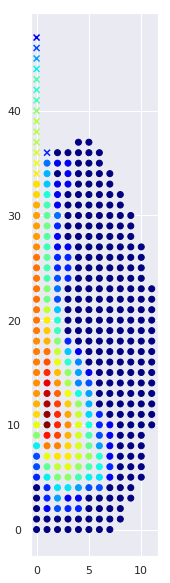

In [26]:
import seaborn as sns
import matplotlib.colors as colors

#TODO remove
support, generator, initial_dist_array = get_support(initial_dist, t_end)
# support = gorde.get_support(all_model_data[0], 10**(-4))
print('support length: {}'.format(len(support)))
print('--')

#for each state visited by a path, determine if it's in the support
support_memberships = raw_data.groupby(species)[species].apply(lambda x: tuple(x.values.flatten()) in support).reset_index(name='in_support')
data = raw_data.merge(support_memberships)

#support_df is just for plotting
support_df = pd.DataFrame(list(support), columns=species)
support_df = support_df.merge(raw_data, on=species, how='left').fillna(0)

def compute_prob_lost():
    number_exited = 0.0
    for path in state_paths:
        path_states = set(map(tuple, path[:,1:]))
        #print(path_states - support)
        if not path_states.issubset(support):
            number_exited += 1.0
    return number_exited / float(len(state_paths))

print('prob. lost: {}'.format(compute_prob_lost()))        
print('support size {}'.format(len(support)))
print()

#print(data.head())

#for the purposes of plotting, combine rows with the same counts for A and B,
#basically we are computing the marginals
marginal_support_df = support_df.groupby(['A', 'B'])['counts'].sum().reset_index()

outside_support_subset = data.iloc[~data['in_support'].values,:]
#thing = outside_support_subset.groupby(['A', 'B'])['counts'].sum().reset_index()
sns.set()

#the counts vary dramatically, so taking the log makes for a better visualization
color_norm = colors.LogNorm(vmin=data['counts'].min(), vmax=data['counts'].max())

outside_support_subset = data.iloc[~data['in_support'].values,:]
plt.scatter(x=outside_support_subset['A'],
            y=outside_support_subset['B'],
            c=outside_support_subset['counts'] + 1,
            marker='x',
            norm=color_norm,
            cmap='jet')

#plot this second
plt.scatter(x=marginal_support_df['A'],
            y=marginal_support_df['B'],
            c=marginal_support_df['counts'] + 1, #add 1 because counts might be zero
            marker='o',
            norm=color_norm,
            cmap='jet')

plt.gcf().set_size_inches(10, 10)
plt.gca().set_aspect('equal')
plt.show()

# Solve the CME

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse.linalg import expm_multiply

t_end = 2.
time_step = 0.1
prob_cutoff = 10**(-8)

t = 0.
dt = 0.
current_dist = initial_dist
stop_after_next_iteration = False

sns.set()
plotting_freq = 2
fig, axes = plt.subplots(int(np.ceil(t_end / time_step / 2 / plotting_freq)) + 1, 2)
fig.set_size_inches(15, 15)
axes = axes.ravel()
for ax in axes:
    ax.set_aspect('equal')
    #TODO made the axes have the same xlim and ylim
subplot_index = 0

lim = np.array([np.inf,-np.inf])

time_step_index = 0
prob_lost = 0.
prob_retained = 1.

while True:
    if time_step_index % plotting_freq == 0:
        #convert current_dist to a pandas dataframe         
        states_arr = np.zeros((len(current_dist), len(species)), dtype=np.int)
        prob_arr = np.zeros(len(current_dist), dtype=np.float)
        for i, (state, prob) in enumerate(current_dist.items()):
            states_arr[i,:] = state
            prob_arr[i] = prob

        df = pd.DataFrame(states_arr, columns=species)
        df['prob'] = prob_arr
#         axes[subplot_index].scatter(x=df['A'],
#                                     y=df['B'],
#                                     c=df['prob'], #add a small number so we do not try to compute log(0)
#                                     marker=',',
#                                     vmin=0,
#                                     s=2.5, #make it 1 square wide
#                                     cmap='jet')
        bins = range(min(df['A'].min(), df['B'].min()),
                     max(df['A'].max(), df['B'].max()) + 1)
        axes[subplot_index].hist2d(x=df['A'],
                                   y=df['B'],
                                   bins=bins,
                                   weights=df['prob'],
                                   cmin=10**(-16), #roughly machine epsilon
                                   cmap='jet',
                                   vmin=0)

        axes[subplot_index].title.set_text('t={}'.format(t))

        lim[0] = min(lim[0], df['A'].min(), df['B'].min())
        lim[1] = max(lim[1], df['A'].max(), df['B'].max())
        
        subplot_index += 1
    
    if stop_after_next_iteration:
        break
    
    if t + time_step >= t_end:
        dt = t_end - t
        stop_after_next_iteration = True
    else:
        dt = time_step
    t += dt
    time_step_index += 1
        
    print('t: {:.4f}'.format(t, dt))
    print('Building the generator matrix...', end='')
    
    #note the multiplication by np.mean(prob_arr)
    mean = np.mean(list(current_dist.values()))
    print('mean: {}'.format(mean))
    support, generator, initial_dist_array = get_support(current_dist, dt, prob_cutoff * mean)
    print('done.')  

    print('Computing the matrix-vector exponential...', end='')
    res_dist = expm_multiply(generator.transpose() * dt, initial_dist_array)
    print('done.')

    prob_lost = res_dist[0]
    print('prob. lost: {:.6E}\n'.format(prob_lost))
    current_dist = {}

    for state, (index, _) in support.items():
        state_prob = res_dist[index]
        
        #might want to remove low probability states, so we do not accumulate too many of them
#         if state_prob >= prob_cutoff:
        current_dist[state] = state_prob

for ax in axes:
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.grid(True)

print('Done.')
plt.show()
    #1 - sum(dist) == prob mass lost
    #take the result to be the new initial dist.
    


# queue test

In [ ]:
import queue
from dataclasses import dataclass, field
from typing import Any
from dataclasses import dataclass

@dataclass(order=True)       
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age
        
q = queue.PriorityQueue()
q.put((1, Person('Andy', 12)))
q.put((2, Person('Barney', 30)))
q.put((0, Person('Charles', 16)))
q.put((2, Person('Dave', 16)))

while not q.empty():
    print(q.get()[1].name)

In [ ]:
%reload_ext line_profiler
import numpy as np
from scipy.stats import poisson

# %lprun -f get_support get_support(initial_dist, 0.1)
def get_probs(y, intensities, dt, parent_multinomial_prob, parent_poisson_prob, reaction_index):
    lmbda0 = np.sum(intensities)
    p = [lmbda/lmbda0 for lmbda in intensities]
    
    for i in range(0, 10**6):
        multinom_prob = parent_multinomial_prob * p[reaction_index] / y[reaction_index] * np.sum(y)
        if np.sum(y) > 1:
            poisson_pmf = parent_poisson_pmf * (dt * lmbda0) / (np.sum(y) - 1)
        else:
            poisson_pmf = np.exp(-lmbda0 * dt)
        return multinom_prob, poisson_pmf
    return multinom_prob, poisson_prob

y = np.array([10, 11, 12])
intensities = np.array([9, 9, 8])
        
%lprun -f get_probs get_probs(y, intensities, 1., 0.1, 0.1, 0)